Эта лабораторная работа посвящена кластеризации. Мы будем работать с рукописными изображениями цифр, научимся их кластеризовать двумя разными методами (иерархическая кластеризация и алгоритм $K$-means), оценивать качество разбиения и выбирать оптимальное число кластеров, а также визуализировать промежуточные результаты.

# 1. Получение данных

Данные, с которыми мы будем работать, доступны в библиотеке scikit-learn (модуль называется `sklearn`) в подмодуле `datasets` через функцию, которая называется `load_digits`. Всего имеется 1797 наблюдений, каждое из них представляет чёрно-белую картинку 8 $\times$ 8 пикселей. Эти картинки – распознанные рукописные цифры от 0 до 9. Образцов написания каждой цифры дано приблизительно поровну, около 180.

Для удобства использования данных каждая картинка "развёрнута" в строку, так что NumPy-массив, в котором хранятся данные, имеет размерность 2 и величину 1797 $\times$ 64 (а не, например, размерность 3 и величину 1797 $\times$ 8 $\times$ 8). Интенсивность цвета в каждом пикселе кодируется целым числом от 0 до 16.

Кроме наблюдений (картинок), известны соответствующие им значения целевой переменной: какую цифру на самом деле изображает каждая картинка. Мы могли бы сразу сформулировать задачу обучения с учителем и предсказывать цифры по картинкам, но для целей этой лабораторной работы мы будем действовать по-другому: сделаем вид, что нам не известны истинные метки классов (т. е. цифры) и даже количество классов, и попробуем сгруппировать данные таким образом, чтобы качество кластеризации оказалось наилучшим, а затем посмотрим, насколько точно полученные кластеры совпадают с группами изображений одинаковых цифр.

Загрузите данные. Добейтесь, чтобы в переменной `X` оказался массив наблюдений, содержащий 1797 $\times$ 64 числа, а в переменной `y` – массив истинных меток классов, содержащий 1797 чисел.

*Указания:*
- Как загрузить данные, объяснено в справке к функции `load_digits`.
- Размер массива хранится в атрибуте `shape`.

In [29]:
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt  # импорт датасета и matplotlib

In [30]:
digits = load_digits()
X = digits.data # загрузка данных
y = digits.target

Визуализируйте первые десять картинок, расположив их на сетке 3 $\times$ 4 (в последнем ряду останутся пустые места). Добейтесь, чтобы фон картинок был белым, а изображения цифр – тёмными.

*Указания:*
- Не забудьте импортировать NumPy и Matplotlib.
- Картинки 8 $\times$ 8 можно либо достать готовыми из объекта, загруженного функцией `load_digits`, либо сделать самостоятельно из строк массива `X`. Во втором случае пользуйтесь методом `reshape`.
- Чтобы изображение не было цветным, можно вызвать функцию `plt.gray`, прежде чем начать рисовать.
- Располагать картинки на сетке умеет функция `plt.subplot`. Ознакомьтесь со справкой к ней.
- По умолчанию число 0 кодирует чёрный цвет, а число 16 – белый цвет. Подумайте, как обратить цвета одной операцией над NumPy-массивом.
- Выводить картинку на экран умеет функция `plt.imshow`. Ознакомьтесь со справкой к ней.
- Если считаете нужным, можете отключить сглаживание – параметр `interpolation` у функции `plt.imshow`.
- Если считаете нужным, можете отключить деления на координатных осях. За это отвечают функции `plt.xticks` и `plt.yticks`.

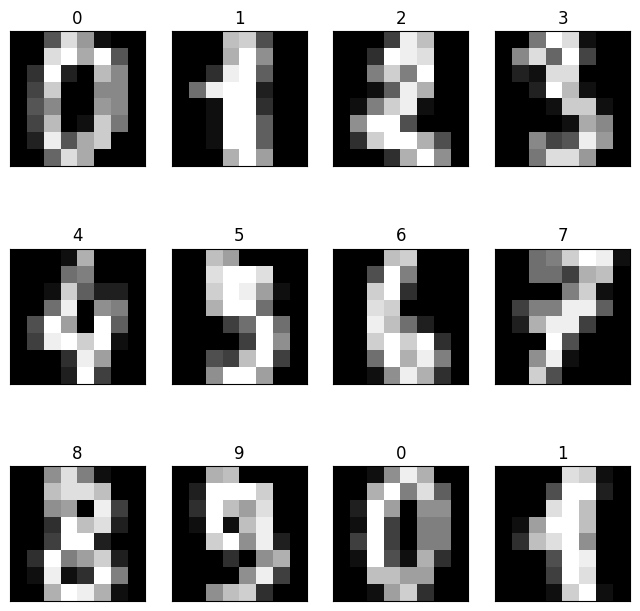

In [31]:
images = digits.images[:12] 


fig, axs = plt.subplots(3, 4, figsize=(8, 8))
for i, ax in enumerate(axs.flat):
    # Инвертирование цветов
    inverted_image = 16 - images[i]
    # Отображение изображения
    ax.imshow(inverted_image, cmap='gray_r', interpolation='nearest')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(digits.target[i])
    
# Визуализация первых 12 изображений 
plt.show()

In [32]:
from sklearn.model_selection import train_test_split # импорт функции разделения данных

X_train, y_train, X_test, y_test = train_test_split(X, y) # разделение данных

# 2. Кластеризация и оценка качества

Мы будем использовать два популярных алгоритма: иерархическую кластеризацию и метод $K$ средних ($K$-means clustering). Эти и другие алгоритмы кластеризации доступны в библиотеке scikit-learn в подмодуле `cluster`. Иерархическая кластеризация называется `AgglomerativeClustering`, а метод $K$ средних – `KMeans`.

Интерфейс у большинства алгоритмов в scikit-learn простой и единообразный:
- Чтобы инициализировать модель, нужно создать экземпляр соответствующего класса со всеми необходимыми параметрами. Например, у кластеризаций единственный обязательный параметр называется `n_clusters`, это количество кластеров, которое мы хотим получить на выходе.
- Инициализированную модель можно обучить, вызвав метод `fit`.
- С помощью обученной модели можно предсказывать, вызывая метод `predict`.

Как видно, этот интерфейс хорош только для задач обучения с учителем, в которых чётко разделены фазы обучения модели и предсказания с её помощью. У кластеризаций зато есть метод `fit_predict`, который разбивает входную выборку на кластеры и сразу же возвращает результаты разбиения.

Используя каждый из двух методов, иерархическую кластеризацию и $K$ средних, получите разбиение массива `X` на 10 кластеров.

*Указания:*
- Оба раза должен получиться массив из 1797 чисел – номеров кластеров.
- `KMeans` делает несколько (по умолчанию 10) запусков со случайными центрами и из полученных разбиений выводит лучшее в терминах среднего внутрикластерного расстояния. Чтобы улучшить качество предсказаний, можно увеличить число запусков, например, до 100. Это параметр `n_init` в конструкторе.

In [33]:
from sklearn.cluster import AgglomerativeClustering, KMeans
import numpy as np  # создание моделей
ac = AgglomerativeClustering(n_clusters=10)
kmeans = KMeans(n_clusters=10, n_init=100, init='k-means++')

In [34]:
kmeans.fit(X) # обучение Kmeans

KMeans(n_clusters=10, n_init=100)

In [35]:
ac.fit(X) # обучение Иерархической кластеризации

AgglomerativeClustering(n_clusters=10)

Визуализируйте центры кластеров, полученных каждым из двух способов. Это опять должны быть картинки на сетке 3 $\times$ 4 с белым фоном и тёмными контурами. Прокомментируйте: какой из двух алгоритмов даёт центры кластеров, больше похожие на типичные начертания цифр?

*Указания:*
- Центр кластера – это среднее по всем наблюдениям, входящим в кластер, т. е. по какому-то набору строк из `X`.
- Чтобы выбрать наблюдения, входящие в кластер номер `i`, используйте индексацию по булевозначной маске. Саму маску можно получить из массива предсказанных номеров кластеров и числа `i` оператором `==`.
- Усреднять NumPy-массив вдоль какой-нибудь из осей умеет функция `np.mean`. Ознакомьтесь со справкой к ней. Нам нужно усреднение по строкам.

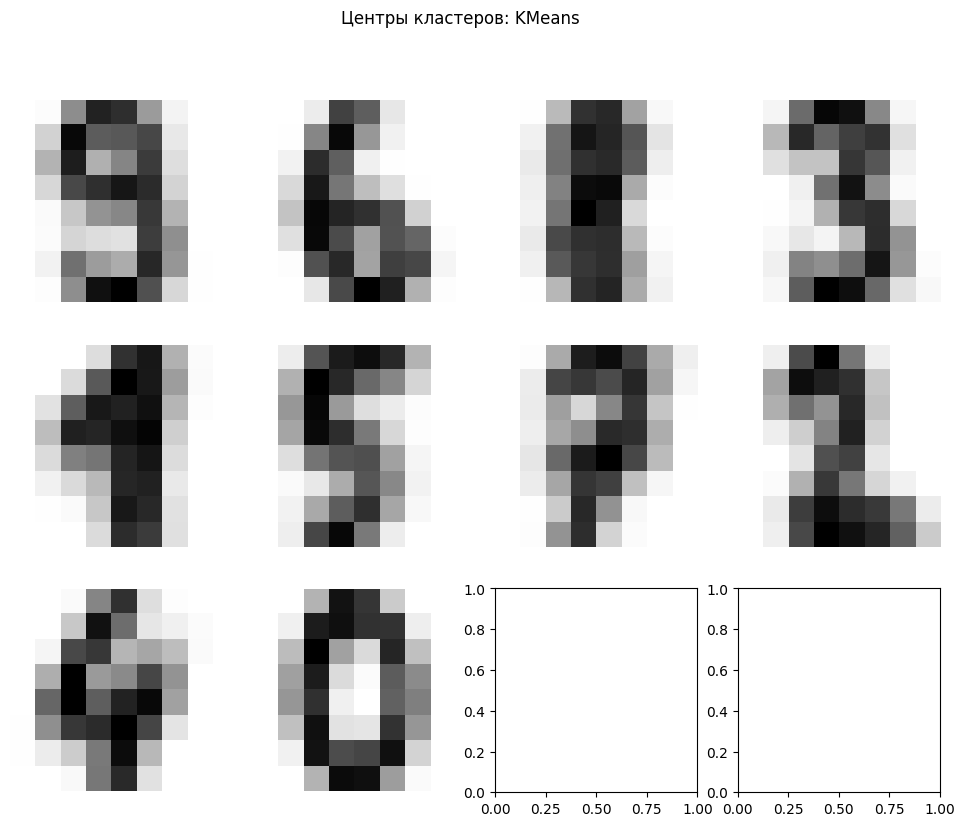

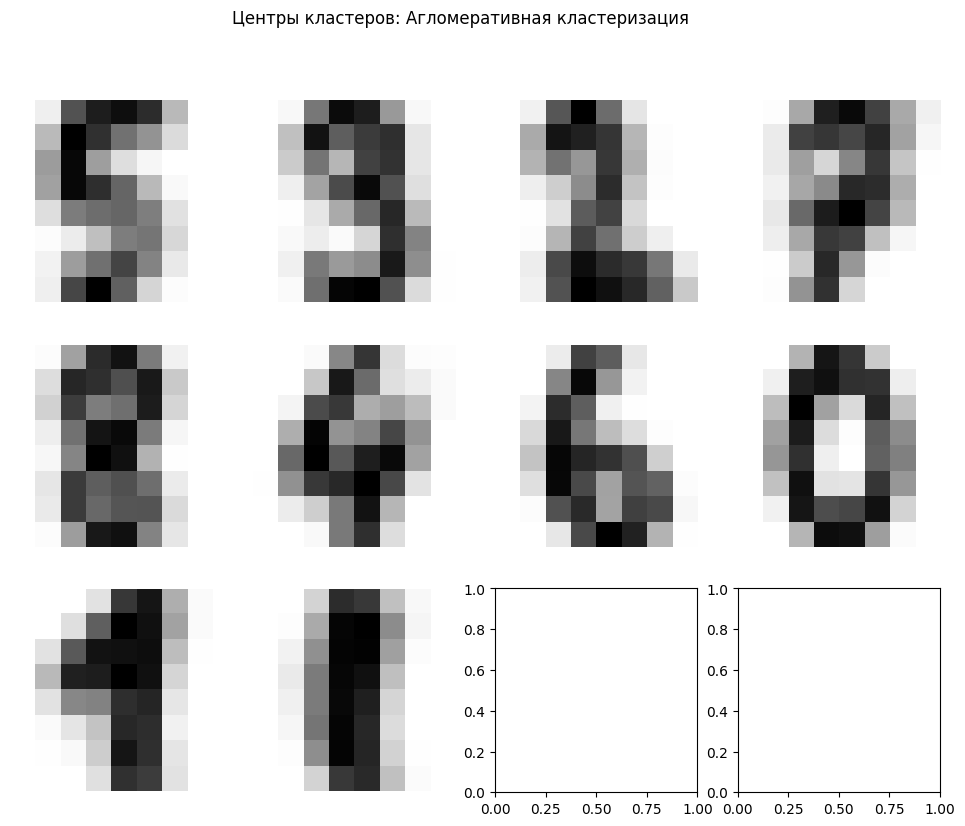

In [36]:
kmeans_centers = kmeans.cluster_centers_
agglomerative_centers = []
for i in range(10):
    mask = ac.labels_ == i
    cluster_points = X[mask]
    cluster_center = np.mean(cluster_points, axis=0)
    agglomerative_centers.append(cluster_center)

# Визуализация центров кластеров
fig, axes = plt.subplots(3, 4, figsize=(12, 9))
for i in range(10):
    row = i // 4
    col = i % 4

    kmeans_center = kmeans_centers[i].reshape(8, 8)
    axes[row, col].imshow(kmeans_center, cmap='binary')
    axes[row, col].axis('off') 

plt.suptitle('Центры кластеров: KMeans')
plt.show()

fig, axes = plt.subplots(3, 4, figsize=(12, 9))
for i in range(10):
    row = i // 4
    col = i % 4
    
    # Агломеративная кластеризация
    agglomerative_center = agglomerative_centers[i].reshape(8, 8)
    axes[row, col].imshow(agglomerative_center, cmap='binary')
    axes[row, col].axis('off')

plt.suptitle('Центры кластеров: Агломеративная кластеризация')
plt.show()

В ситуации, когда истинное число кластеров неизвестно, подбирают оптимальное число кластеров. При этом учитывают две величины: внутрикластерное расстояние (чем меньше, тем лучше) и межкластерное расстояние (чем больше, тем лучше). Так как две эти величины не достигают оптимума одновременно, обычно оптимизируют какой-нибудь функционал от них. Один популярный функционал называется "силуэт" (silhouette). Вот как он вычисляется.

Пусть $X$ – множество наблюдений, $M \subset X$ – один из кластеров, на которые оно разбито в результате кластеризации, $\rho$ – метрика на $X$. Выберем какое-нибудь одно наблюдение $x \in M$. Обозначим $a(x)$ среднее расстояние от $x$ до точек $x'$ из того же кластера:
$$
a(x) = \frac{1}{|M|} \sum_{x' \in M} \rho(x,\, x')
$$

Обозначим $b(x)$ минимум средних расстояний от $x$ до точек $x''$ из какого-нибудь другого кластера $N$:
$$
b(x) = \min_{N \ne M} \frac{1}{|N|} \sum_{x'' \in N} \rho(x,\, x'')
$$

Силуэт – это разность межкластерного и внутрикластерного расстояний, нормированная до отрезка $[-1,\, 1]$ и усреднённая по всем наблюдениям:
$$
\frac{1}{|X|} \sum_{x \in X} \frac{b(x) - a(x)}{\max(a(x),\, b(x))}
$$

В scikit-learn силуэт считается функцией `silhouette_score` из подмодуля `metrics`. На вход нужно передать массив наблюдений и результат кластеризации.


Для числа $K$ от 2 до 20 включительно получите разбиение массива `X` на $K$ кластеров каждым из двух методов. Посчитайте силуэт. Посчитанные значения силуэта сохраните в переменную и визуализируйте в виде графика в координатах: число $K$ – значение силуэта. При каком числе кластеров достигается максимум силуэта?

*Указания:*
- Не забудьте, что функция `range` не захватывает правый конец диапазона.
- Под значения силуэта можно завести два списка: один для иерархической кластеризации, другой для $K$ средних.
- Рисовать графики умеет функция `plt.plot`. Ознакомьтесь со справкой к ней.
- На одной картинке можно разместить несколько графиков, это просто несколько последовательных вызовов `plt.plot`.
- Чтобы добавить легенду (подписи к графикам), можно воспользоваться функцией `plt.legend`. Местоположение легенды контролируется параметром `loc`.
- Чтобы подписать координатные оси, можно воспользоваться функциями `plt.xlabel` и `plt.ylabel`.

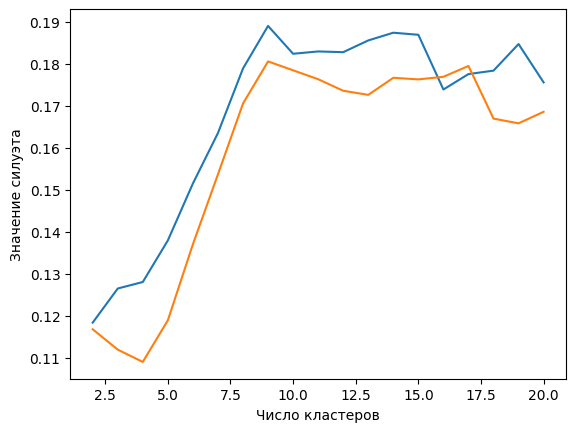

In [37]:
from sklearn.metrics import silhouette_score

silhouette_scores_kmeans = []
silhouette_scores_agglomerative = []

# Вычисление силуэта для разного числа кластеров
for n_clusters in range(2, 21):
    # KMeans
    kmeans = KMeans(n_clusters=n_clusters, n_init=100, init='k-means++')
    kmeans_labels = kmeans.fit_predict(X)
    kmeans_silhouette = silhouette_score(X, kmeans_labels)
    silhouette_scores_kmeans.append(kmeans_silhouette)
    # Agglomerative
    agglomerative = AgglomerativeClustering(n_clusters=n_clusters)
    agglomerative_labels = agglomerative.fit_predict(X)
    agglomerative_silhouette = silhouette_score(X, agglomerative_labels)
    silhouette_scores_agglomerative.append(agglomerative_silhouette)

plt.plot(range(2, 21), silhouette_scores_kmeans, label='KMeans')
plt.plot(range(2, 21), silhouette_scores_agglomerative, label='Agglomerative') # Визуализация
plt.xlabel('Число кластеров')
plt.ylabel('Значение силуэта') #
plt.show()

Когда известно "правильное" (в каком-нибудь смысле) разбиение на кластеры, результат кластеризации можно сравнить с ним, используя такие меры, как однородность (homogeneity), полнота (completeness) и их среднее гармоническое – $V$-мера. Определения этих величин довольно громоздкие и основаны на понятии [энтропии распределения вероятностей](https://ru.wikipedia.org/wiki/Информационная_энтропия); подробности излагаются в [этой статье](http://aclweb.org/anthology/D/D07/D07-1043.pdf). На практике достаточно знать, что однородность, полнота и $V$-мера заключены между нулём и единицей – чем больше, тем лучше.

Так как мы знаем, какую цифру на самом деле изображает каждая картинка (это массив `y`), мы можем использовать однородность, полноту и $V$-меру для оценки качества кластеризации. Функции для вычисления этих величин доступны в scikit-learn, в подмодуле `metrics`, под названиями `homogeneity_score`, `completeness_score`, `v_measure_score`. Как вариант, можно использовать функцию `homogeneity_completeness_v_measure`, которая возвращает сразу тройку чисел.

Повторите предыдущее задание, используя $V$-меру вместо силуэта. При каком числе кластеров достигается максимум $V$-меры?

In [52]:
from sklearn.metrics import v_measure_score # импорт 

vs_kmeans = []
vs_agglomerative = [] # списки v-мер при разных количествах кластеров
for n_clusters in range(2, 21):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0, init='k-means++')
    labels = kmeans.fit_predict(X) # обучение Kmeans и запись v-меры в список
    v_measure = v_measure_score(y, labels)
    vs_kmeans.append(v_measure)

for n_clusters in range(2, 21):  # тоже самое но с иерархической кластеризацией
    agglomerative = AgglomerativeClustering(n_clusters=n_clusters)
    labels = agglomerative.fit_predict(X)
    v_measure = v_measure_score(y, labels)
    vs_agglomerative.append(v_measure)

print(f"Максимальная v-mera в Иерархической кластризации: {max(vs_agglomerative)}, при количестве кластеров: {vs_agglomerative.index(max(vs_agglomerative))}")
print(f"Максимальная v-mera в KMeans: {max(vs_kmeans)}, при количестве кластеров: {vs_kmeans.index(max(vs_kmeans))}") 

before_vs_decomposition_kmeans = max(vs_kmeans)
before_vs_decomposition_agglomerative = max(vs_agglomerative)

C:\Users\kaspe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\kaspe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\kaspe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the v

Максимальная v-mera в Иерархической кластризации: 0.86854875186737, при количестве кластеров: 10
Максимальная v-mera в KMeans: 0.7774888826102532, при количестве кластеров: 12


# 3. Снижение размерности признакового пространства

Иногда, особенно когда признаков много и не все они одинаково информативные, бывает полезно снизить размерность признакового пространства, то есть вместо $d$ исходных признаков перейти к рассмотрению $d' \ll d$ новых признаков. Данные были представлены матрицей $n$ наблюдений $\times$ $d$ исходных признаков, а теперь будут представлены матрицей $n$ наблюдений $\times$ $d'$ новых признаков.

Есть два популярных подхода к снижению размерности:
- отобрать (select) новые признаки из числа имеющихся;
- извлечь (extract) новые признаки, преобразуя старые, например, сделать $d'$ различных линейных комбинаций столбцов исходной матрицы $n \times d$.

Одним из широко используемых методов извлечения признаков является сингулярное разложение матрицы (singular value decomposition, SVD). Этот метод позволяет сконструировать любое число $d' \le d$ новых признаков таким образом, что они будут, в определённом смысле, максимально информативными. Математические детали сейчас не важны; познакомиться с ними можно, например, [здесь](https://www.coursera.org/learn/mathematics-and-python/lecture/L9bCV/razlozhieniia-matrits-v-proizviedieniie-singhuliarnoie-razlozhieniie)
(по-русски) или [здесь](https://www.youtube.com/watch?v=P5mlg91as1c) (по-английски).

В scikit-learn есть несколько реализаций сингулярного разложения. Мы будем использовать класс `TruncatedSVD` из подмодуля `decomposition`. В конструктор этого класса достаточно передать один параметр `n_components` – желаемое число новых признаков. Метод `fit_transform` принимает матрицу и возвращает новую матрицу с таким же количеством строк, как прежде, и количеством столбцов, равным числу новых признаков.

*<u>Замечание:</u>* Сингулярное разложение матрицы $M$ обычно пишут в виде $M = U \Sigma V^{*}$, где $U$, $\Sigma$ и $V$ – некие матрицы с хорошими свойствами. То, что возвращает алгоритм `TruncatedSVD`, – это сколько-то (сколько мы хотим получить) первых столбцов матрицы $U$.

Выполните сингулярное разложение матрицы `X`, оставляя 2, 5, 10, 20 признаков. В каждом случае выполните иерархическую и $K$-means кластеризацию преобразованных данных (число кластеров примите равным 10). Посчитайте значения силуэта и $V$-меры. Удалось ли при каком-нибудь $d'$ получить силуэт и / или $V$-меру лучше, чем на исходных данных?

In [39]:
from sklearn.decomposition import TruncatedSVD # импорт

In [53]:
n_components_values = [2, 5, 10, 20]

vms_kms = []
vms_agg = []
# Перебираем разные значения n_components
for n_components in n_components_values:
    # Выполняем сингулярное разложение
    svd = TruncatedSVD(n_components=n_components, random_state=0)
    transformed_data = svd.fit_transform(X)
    # Выполняем кластеризацию
    agglomerative_clustering = AgglomerativeClustering(n_clusters=10)
    kmeans_clustering = KMeans(n_clusters=10, random_state=0)
    agglomerative_labels = agglomerative_clustering.fit_predict(transformed_data)
    kmeans_labels = kmeans_clustering.fit_predict(transformed_data)
    # Вычисляем значения силуэта и V-меры
    silhouette = silhouette_score(transformed_data, kmeans_labels)
    v_measure_kms = v_measure_score(y, kmeans_labels)
    vms_kms.append(v_measure_kms)
    v_measure_agg = v_measure_score(y, agglomerative_labels)
    vms_agg.append(v_measure_agg)
    # Выводим результат
    print(f"Number of components: {n_components}")
    print(f"Silhouette score: {silhouette}")
    print(f"V-measure score: {v_measure}")

print(f'В Kmeans с сингулярным разложением v-measure получилось лучше чем без него' if max(vms_kms) > before_vs_decomposition_kmeans else "В Kmeans с сингулярным разложением v-measure получилось хуже чем без него")
print(f'В Agg_clust с сингулярным разложением v-measure получилось лучше чем без него' if max(vms_agg) > before_vs_decomposition_agglomerative else "В Agg_clust с сингулярным разложением v-measure получилось хуже чем без него")

C:\Users\kaspe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\kaspe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Number of components: 2
Silhouette score: 0.3486715525984666
V-measure score: 0.8250943463532207
Number of components: 5
Silhouette score: 0.31257940721760824
V-measure score: 0.8250943463532207


C:\Users\kaspe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\kaspe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Number of components: 10
Silhouette score: 0.263196520590263
V-measure score: 0.8250943463532207
Number of components: 20
Silhouette score: 0.2123859726318096
V-measure score: 0.8250943463532207
В Kmeans с сингулярным разложением v-measure получилось хуже чем без него
В Agg_clust с сингулярным разложением v-measure получилось хуже чем без него


Другая популярная техника снижения размерности, которая особенно хорошо подходит для работы с картинками, – это алгоритм t-distributed stochastic neighbor embeddings, сокращённо tSNE. В отличие от сингулярного разложения, это преобразование нелинейное. Его основная идея – отобразить точки из пространства размерности $d$ в пространство размерности 2 или 3 (обычно 2, то есть на плоскость) таким образом, чтобы как можно точнее сохранить расстояния. Математические детали есть, например, [здесь](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding), но они нетривиальны.

В библиотеке scikit-learn реализацией tSNE является класс `TSNE` в подмодуле `manifold`. В конструктор можно передать параметр `n_components`, а можно и не передавать: по умолчанию он равен 2. Метод `fit_transform` работает аналогично тому, как и у `TruncatedSVD`.


Выполните tSNE-преобразование матрицы `X`, оставив 2 признака. Визуализируйте данные, преобразованные таким образом, в виде точечной диаграммы: первый признак вдоль горизонтальной оси, второй признак вдоль вертикальной оси. Подсветите разными цветами группы точек, соответствующих разным цифрам.

*Указания:*
- Точечную диаграмму умеет рисовать функция `plt.scatter`. Ознакомьтесь со справкой к ней.
- За цвета точек отвечает параметр `c` у функции `plt.scatter`. Передать в него надо истинные метки классов.

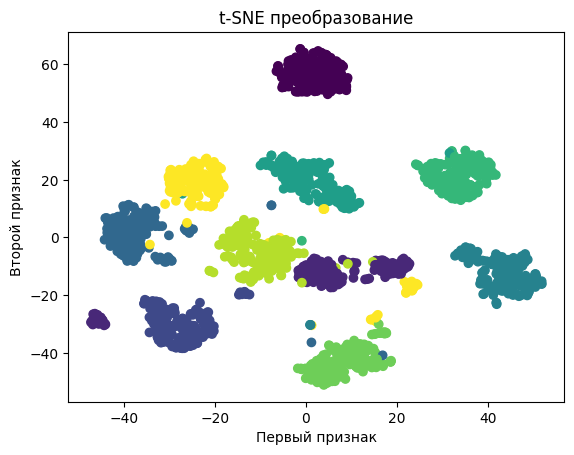

In [45]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
X_prepared = tsne.fit_transform(X)# визуализация данных сниженной размерности
plt.scatter(X_prepared[:, 0], X_prepared[:, 1], c=y)
plt.xlabel('Первый признак')
plt.ylabel('Второй признак')
plt.title('t-SNE преобразование')
plt.show()

Для tSNE-преобразованных данных с 2 признаками выполните иерархическую и $K$-means кластеризацию (число кластеров примите равным 10). Посчитайте значения силуэта и $V$-меры. Удалось ли получить силуэт и / или $V$-меру лучше, чем на исходных данных?

In [54]:
agglomerative_clustering = AgglomerativeClustering(n_clusters=10)
agglomerative_labels = agglomerative_clustering.fit_predict(X_prepared)

kmeans = KMeans(n_clusters=10)
kmeans_labels = kmeans.fit_predict(X_prepared)

# Расчет силуэта
silhouette_tsne = silhouette_score(X_prepared, agglomerative_labels)
silhouette_kmeans = silhouette_score(X_prepared, kmeans_labels)

# Расчет V-меры
v_measure_tsne = v_measure_score(y, agglomerative_labels)
v_measure_kmeans = v_measure_score(y, kmeans_labels)

print("Силуэт agglomerative", silhouette_tsne)
print("Силуэт kmeans", silhouette_kmeans)
print("V-мера agglomerative", v_measure_tsne)
print("V-мера kmeans", v_measure_kmeans)

Силуэт agglomerative 0.63866305
Силуэт kmeans 0.6422183
V-мера agglomerative 0.911056555346593
V-мера kmeans 0.9116334462095017


C:\Users\kaspe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Для самого лучшего разбиения, которое вам удалось получить (на ваше усмотрение, лучшего в терминах силуэта или $V$-меры), опять визуализируйте картинками центры кластеров. Удалось ли добиться, чтобы каждый кластер соответствовал какой-нибудь одной цифре?

C:\Users\kaspe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


ValueError: cannot reshape array of size 2 into shape (8,8)

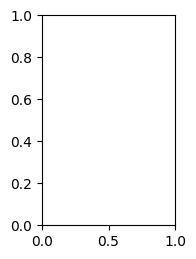

In [57]:
kmeans = KMeans(n_clusters=10)
kmeans_labels = kmeans.fit_predict(X_prepared)
cluster_centers = kmeans.cluster_centers_

# Визуализация центров кластеров в виде изображений
plt.figure(figsize=(10, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    center = cluster_centers[i]
    center_image = center.reshape((8, 8))
    plt.imshow(center_image, cmap='binary')
    plt.title(f'Cluster {i}')
    plt.axis('off')
plt.suptitle('Центры кластеров (t-SNE + K-means)')
plt.tight_layout()
plt.show()

## с этим возникли сложности

# 4. Итоги

Напишите в свободной форме, какие выводы вы сделали из выполненной работы. Ответьте, как минимум, на следующие два вопроса:
- Какой из двух методов даёт более осмысленные кластеры – иерархическая кластеризация или алгоритм $K$ средних? Зависит ли это от настроек каждого алгоритма? От критериев оценивания качества?
- Удаётся ли улучшить качество кластеризации, снижая размерность признакового пространства?

1. Как я выяснил, если не указывать количество точное количество параметров, то Иерархическая клатеризация определяет точнее используя силуэт и v-меру. 
2. Да, v-мера увеличилась с 0.77 до 0.91

Скачайте датасет [MNIST Handwritten Digits](http://yann.lecun.com/exdb/mnist). Как сделать это с помощью scikit-learn, написано [здесь](http://scikit-learn.org/stable/datasets/index.html#downloading-datasets-from-the-mldata-org-repository). MNIST Handwritten Digits – это 70 тысяч распознанных рукописных изображений цифр, каждое размером 28 $\times$ 28 пикселей. Попробуйте прокластеризовать этот датасет и добиться как можно лучших значений силуэта и $V$-меры.

Не успел
